In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1153).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (352).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (672).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (405).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (436).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (564).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (936).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (837).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (421).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (221).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVI

## Setup

In [2]:
# Setup

import time
import os
import copy
import torch
import torchvision
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.io as io
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
import torch.optim as opt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
from tqdm.notebook import tqdm
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data

In [3]:
Data_Directory="../input/sarscov2-ctscan-dataset"

# Data directory and classes
data_dir="../input/sarscov2-ctscan-dataset"

print("Folders in Data set : ",os.listdir(data_dir))
classes=os.listdir(data_dir)
print("Classes : ",classes)



print("abnormal images : ",len(os.listdir(data_dir+'/COVID')))
print("normal images : ",len(os.listdir(data_dir+'/non-COVID')))

Folders in Data set :  ['non-COVID', 'COVID']
Classes :  ['non-COVID', 'COVID']
abnormal images :  1252
normal images :  1229


In [4]:
## Split into train,val,test

!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio(data_dir,output="output",seed=1337 ,ratio=(.9,.1))

Copying files: 2481 files [00:14, 166.39 files/s]


In [6]:
whole_train="./output/train"
splitfolders.ratio(whole_train,output="./output/train-val",seed=1337 ,ratio=(.9,.1))

Copying files: 2232 files [00:00, 4693.82 files/s]


In [7]:
train_ds_path="./output/train-val/train"
val_ds_path="./output/train-val/val"
test_ds_path="./output/val"
full_ds_path="./output/train"



print("train images : ",len(os.listdir(train_ds_path+'/COVID'))+len(os.listdir(train_ds_path+'/non-COVID')))
print("val images : ",len(os.listdir(val_ds_path+'/COVID'))+len(os.listdir(val_ds_path+'/non-COVID')))
print("test images : ",len(os.listdir(test_ds_path+'/COVID'))+len(os.listdir(test_ds_path+'/non-COVID')))
print("whole training images : ",len(os.listdir(full_ds_path+'/COVID'))+len(os.listdir(full_ds_path+'/non-COVID')))

print("\n")
print("abnormal train images : ",len(os.listdir(train_ds_path+'/COVID')))
print("abnormal val images : ",len(os.listdir(val_ds_path+'/COVID')))
print("abnormal test images : ",len(os.listdir(test_ds_path+'/COVID')))
print("abnormal whole training images : ",len(os.listdir(full_ds_path+'/COVID')))
print("\n")
print("normal train images : ",len(os.listdir(train_ds_path+'/non-COVID')))
print("normal val images : ",len(os.listdir(val_ds_path+'/non-COVID')))
print("normal test images : ",len(os.listdir(test_ds_path+'/non-COVID')))
print("normal whole training images : ",len(os.listdir(full_ds_path+'/non-COVID')))

train images :  2008
val images :  224
test images :  249
whole training images :  2232


abnormal train images :  1013
abnormal val images :  113
abnormal test images :  126
abnormal whole training images :  1126


normal train images :  995
normal val images :  111
normal test images :  123
normal whole training images :  1106


In [8]:
# Data transforms (normalization & data augmentation)
# Initially PIL Images
# ToTensor: convert PIL Image to tensor and values normalized 0 to 1
train_tfms = tt.Compose([
                         tt.Resize((224,224)),
                        #  tt.RandomRotation(degrees=(-20,20)),
                         tt.ToTensor()])
val_tfms = tt.Compose([
                       tt.Resize((224,224)),
                         tt.ToTensor()])
test_tfms = tt.Compose([
                        tt.Resize((224,224)),
                         tt.ToTensor()])

### Datasets

In [9]:
train_ds=ImageFolder(train_ds_path, transform=train_tfms)
val_ds=ImageFolder(val_ds_path, transform=val_tfms)
test_ds=ImageFolder(test_ds_path, transform=test_tfms)
full_ds=ImageFolder(full_ds_path, transform=train_tfms)
# test_dataset=test_ds

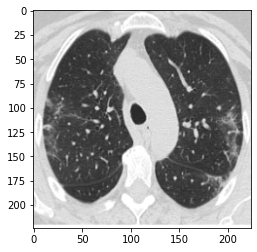

In [10]:
for img,label in train_ds:
  img=img.squeeze_()
  img=img.permute(1,2,0)
  plt.imshow(img,cmap="gray")
  break

### Data Loader

In [11]:
batch_size = 20
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
# test_dataloader=test_dl

## Model

### GPU

In [12]:
### GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Plotting

In [13]:
def plot_confusion_matrix(data_loader,nb_classes):
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    y_pred=[]
    y_true=[]
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(val_dl):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            outs=preds.detach().cpu().numpy()
            classess=classes.detach().cpu().numpy()
            y_pred=np.concatenate((y_pred,outs),axis=None)
            y_true=np.concatenate((y_true,classess),axis=None)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    array=confusion_matrix(y_pred,y_true)
    classes=os.listdir(data_dir)
    df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Squeezenet

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item(),dtype=torch.float32)


class ImageClassificationBase(nn.Module):
    def training_step(self,batch, loss_func):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_func(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch,loss_func):
        images, labels = batch
        out = self(images)                    # Generate predictions
        # print("out : ",out)
        # print("labels : ",labels)
        loss = loss_func(out, labels)   # Calculate loss
        crct_pred = accuracy(out, labels)           # Calculate accuracy
        # print("crct_pred ",crct_pred," batch_size : ",20)
        return {'val_loss': loss.detach(), 'crct_pred': crct_pred, 'batch_size' : len(images)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_sizes=[x['batch_size'] for x in outputs]
        net_size=sum(batch_sizes)
        crct_preds = [x['crct_pred'] for x in outputs]
        epoch_acc = sum(crct_preds)/net_size
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
    def pred(self,img):
      out=self(img)
      return out
    def predictions(self,images):
      outputs=self(images)
      _, preds = torch.max(outputs, dim=1)
      return preds


In [15]:
@torch.no_grad()
def evaluate(model, val_loader,loss_func):
    model.eval()
    outputs = [model.validation_step(batch,loss_func) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader,loss_func, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None,loss_func=F.cross_entropy, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up cosine annealing lr learning rate scheduler
    count=0
    for batch in tqdm(train_loader):
      count=count+1
    num_iter=count*epochs
    sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#### With out Freezing

In [18]:
class SQUEEZENET_WoF(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network =models.squeezenet1_0(pretrained=pretrained)
        # Replace last layer
        self.network.classifier[1]= nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        for param in self.network.classifier.parameters():
          param.requires_grad = True
          
    def forward(self, xb):
        return self.network(xb)

##### Cross Entropy

In [19]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy

# Model
model=SQUEEZENET_WoF(num_classes)
to_device(model,device)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


  0%|          | 0.00/4.79M [00:00<?, ?B/s]

SQUEEZENET_WoF(
  (network): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

In [20]:
torch.manual_seed(42)
k=5
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [21]:
def train_epoch(model,device,dataloader,scheduler,loss_fn=F.cross_entropy,optimizer=torch.optim.Adam,grad_clip=0):

    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        if grad_clip:
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,num_classes,device,dataloader,loss_fn=F.cross_entropy,grad_clip=0):
  valid_loss, val_correct = 0.0, 0
  y_true=[]
  y_pred=[]
  model.eval()
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)

  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()
  
  return valid_loss,val_correct

def cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip):
  foldperf={}
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(full_ds)))):

      print('Fold {}'.format(fold + 1))

      train_sampler = SubsetRandomSampler(train_idx)
      test_sampler = SubsetRandomSampler(val_idx)
      train_loader = DataLoader(full_ds, batch_size=batch_size, sampler=train_sampler)
      test_loader = DataLoader(full_ds, batch_size=batch_size, sampler=test_sampler)
    
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
      model.to(device)
      print(loss_func)
      optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
      # Set up cosine annealing lr learning rate scheduler
      count=0
      for batch in tqdm(train_loader):
        count=count+1
      num_iter=count*num_epochs
      sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

      history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

      for epoch in range(num_epochs):
          train_loss, train_correct=train_epoch(model,device,train_loader,sched,loss_func,optimizer,grad_clip)
          test_loss, test_correct=valid_epoch(model,num_classes,device,test_loader,loss_func,grad_clip)

          train_loss = train_loss / len(train_loader.sampler)
          train_acc = train_correct / len(train_loader.sampler) * 100
          test_loss = test_loss / len(test_loader.sampler)
          test_acc = test_correct / len(test_loader.sampler) * 100

          print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
          history['train_loss'].append(train_loss)
          history['test_loss'].append(test_loss)
          history['train_acc'].append(train_acc)
          history['test_acc'].append(test_acc)
      
      foldperf['fold{}'.format(fold+1)] = history  

  torch.save(model,'k_cross_CNN.pt')
  return foldperf


def test(model,device,dataloader,test_dataset,loss_fn):
  test_loss, test_correct = 0.0, 0
  model.eval()
  y_true=[]
  y_pred=[]
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      test_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      test_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)
    
  test_loss = test_loss / len(test_dataset)
  test_acc = test_correct / len(test_dataset) * 100
  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()

  return test_loss,test_acc

  test_loss = test_loss / len(test_dataset)
  test_acc = test_correct / len(test_dataset) * 100


def cv_results(foldperf):
  testl_f,tl_f,testa_f,ta_f=[],[],[],[]
  testl_fm,tl_fm,testa_fm,ta_fm=[],[],[],[]
  for f in range(1,k+1):

      tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
      testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

      ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
      testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))
      tl_fm.append(np.max(foldperf['fold{}'.format(f)]['train_loss']))
      testl_fm.append(np.max(foldperf['fold{}'.format(f)]['test_loss']))

      ta_fm.append(np.max(foldperf['fold{}'.format(f)]['train_acc']))
      testa_fm.append(np.max(foldperf['fold{}'.format(f)]['test_acc']))

  print('Performance of {} fold cross validation'.format(k))
  print("Average Training Loss: {:.3f} \t Average val Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average val Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))  
  print("Max Training Acc: {:.2f} \t Max val Acc: {:.2f}".format(np.max(ta_fm),np.max(testa_fm)))  

Fold 1
<function cross_entropy at 0x7fc09dd60ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

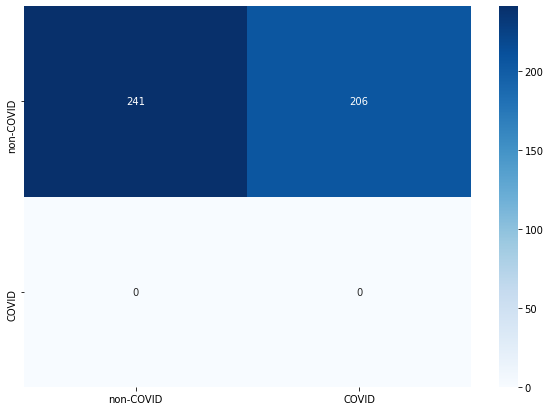

Epoch:1/10 AVG Training Loss:1.154 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


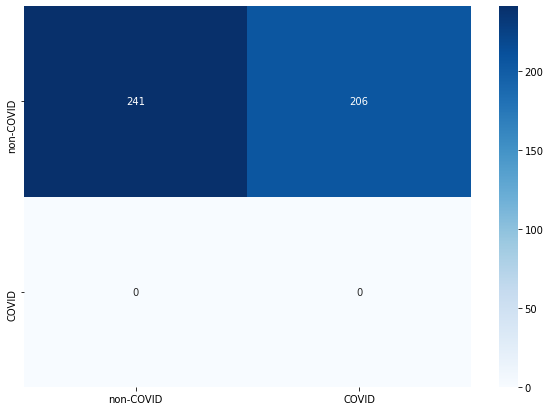

Epoch:2/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


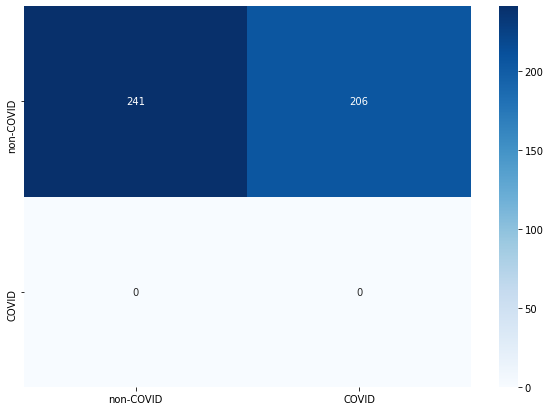

Epoch:3/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


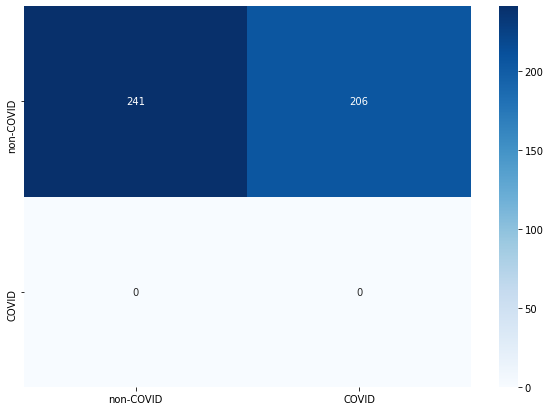

Epoch:4/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


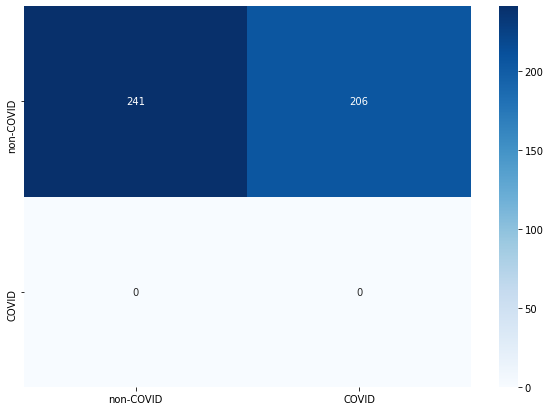

Epoch:5/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


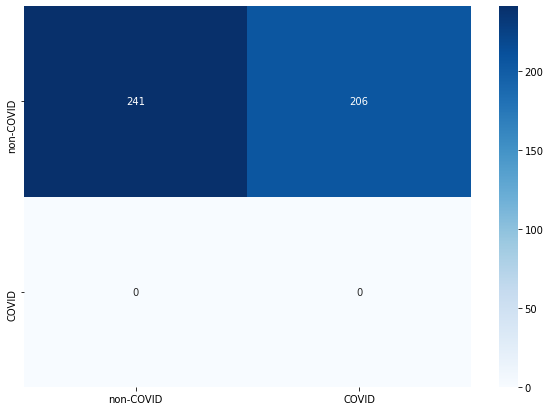

Epoch:6/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


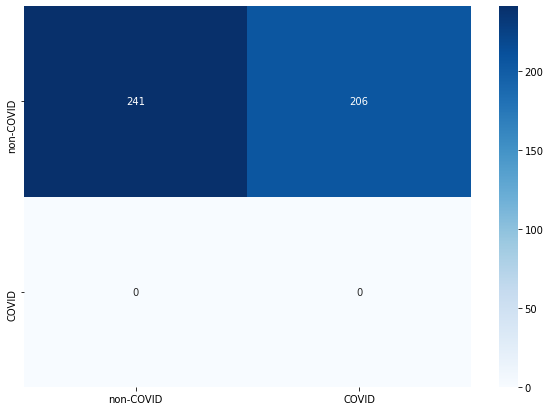

Epoch:7/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


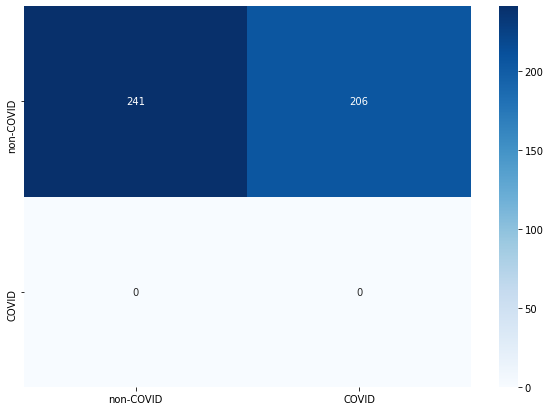

Epoch:8/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


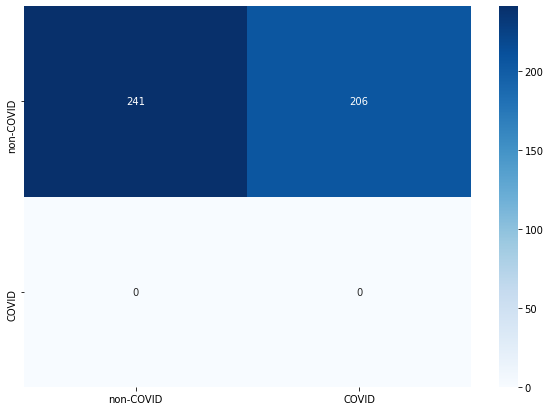

Epoch:9/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


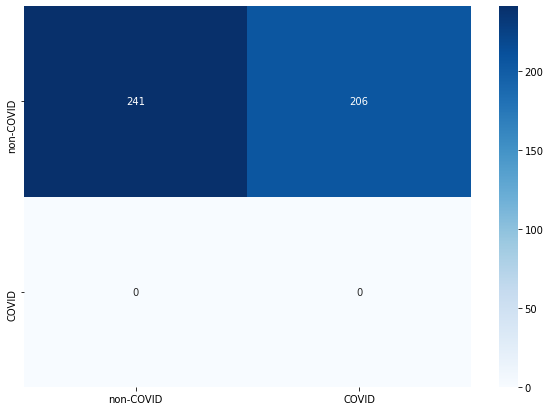

Epoch:10/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 49.58 % AVG Test Acc 53.91 %
Fold 2
<function cross_entropy at 0x7fc09dd60ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

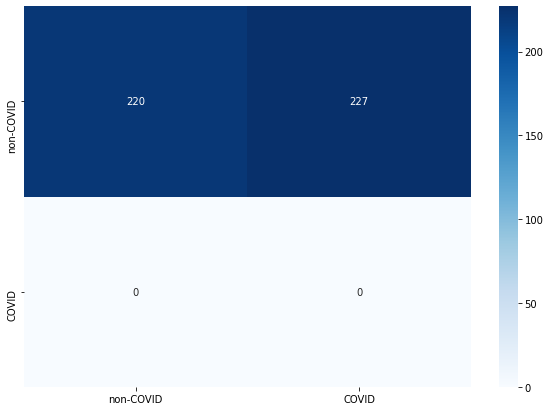

Epoch:1/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.59 % AVG Test Acc 49.22 %


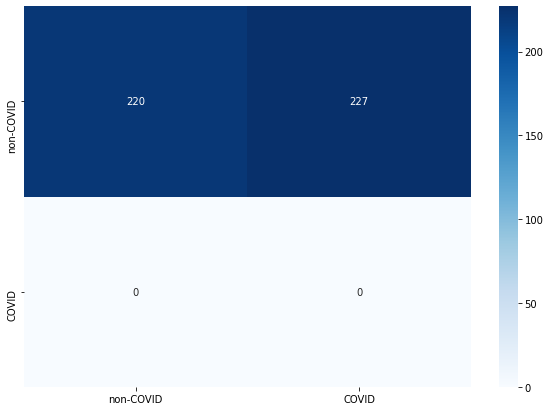

Epoch:2/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


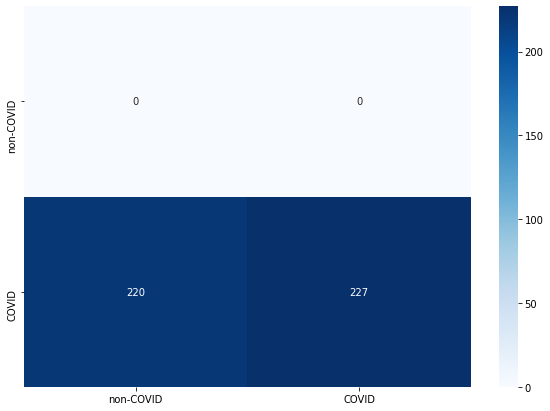

Epoch:3/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.08 % AVG Test Acc 50.78 %


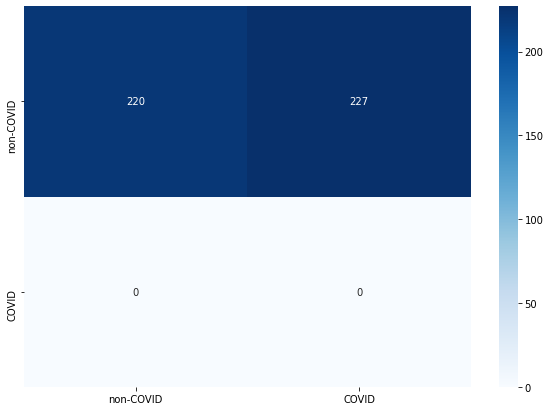

Epoch:4/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.98 % AVG Test Acc 49.22 %


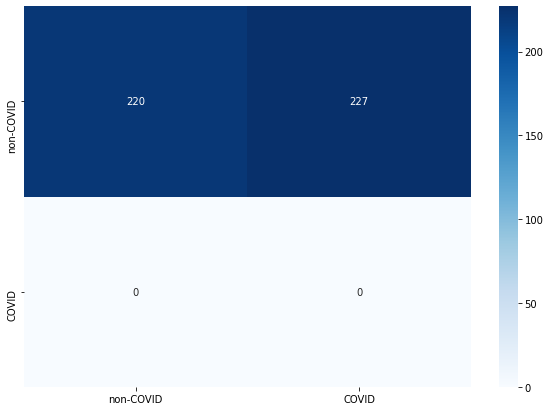

Epoch:5/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


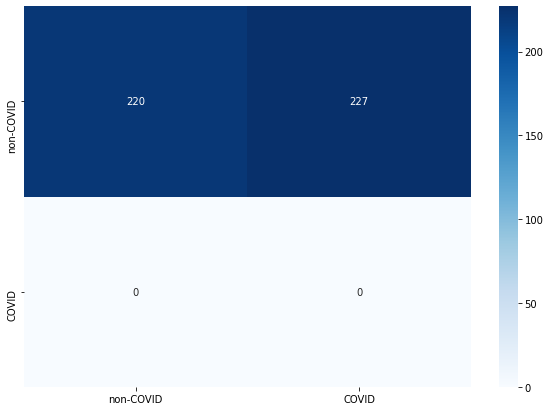

Epoch:6/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


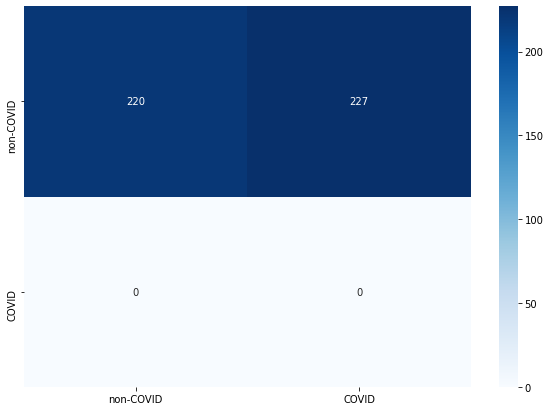

Epoch:7/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


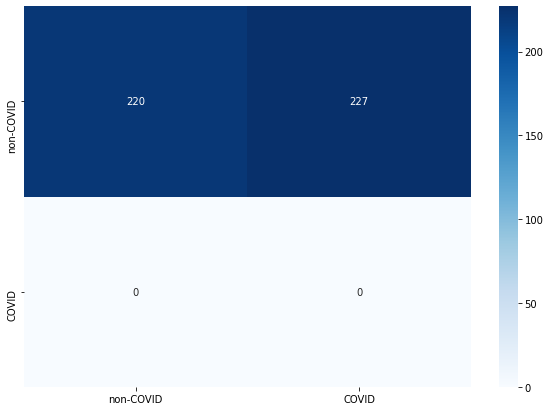

Epoch:8/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


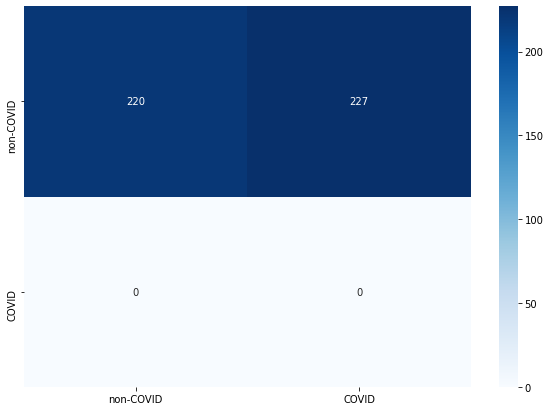

Epoch:9/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %


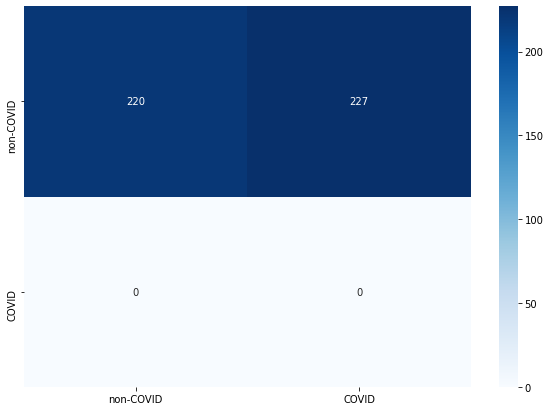

Epoch:10/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.76 % AVG Test Acc 49.22 %
Fold 3
<function cross_entropy at 0x7fc09dd60ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

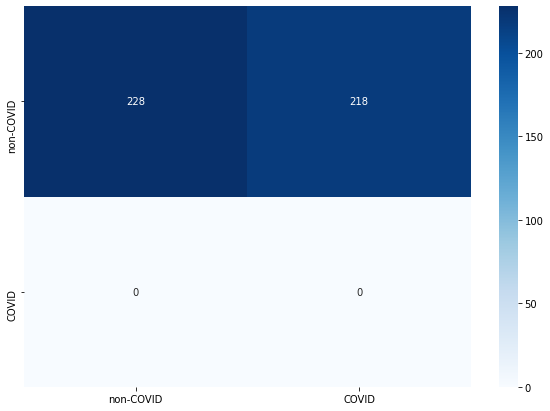

Epoch:1/10 AVG Training Loss:0.696 AVG Test Loss:0.693 AVG Training Acc 50.95 % AVG Test Acc 51.12 %


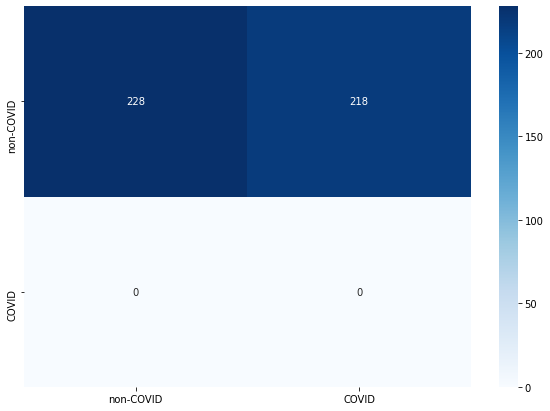

Epoch:2/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.06 % AVG Test Acc 51.12 %


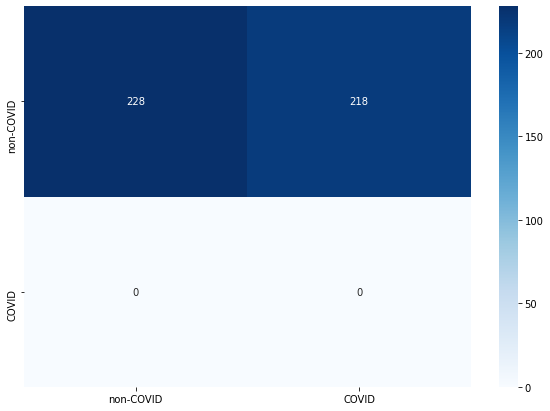

Epoch:3/10 AVG Training Loss:0.694 AVG Test Loss:0.693 AVG Training Acc 51.34 % AVG Test Acc 51.12 %


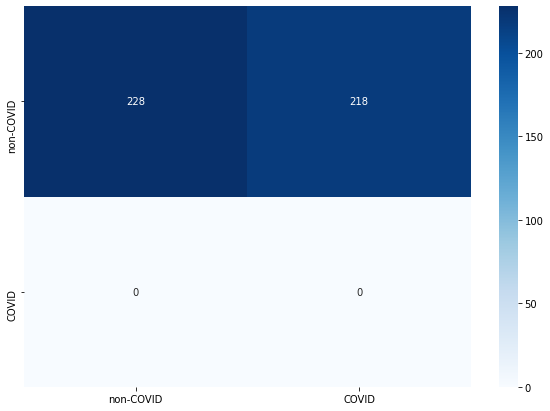

Epoch:4/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


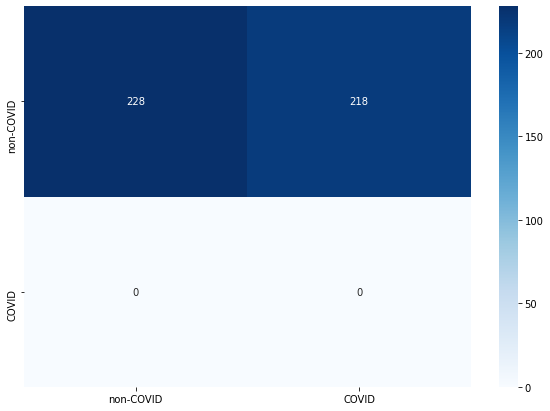

Epoch:5/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


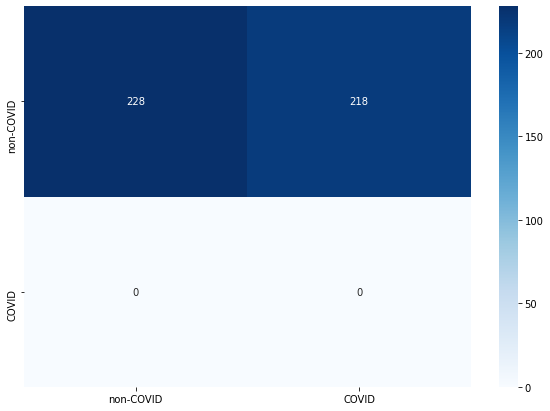

Epoch:6/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


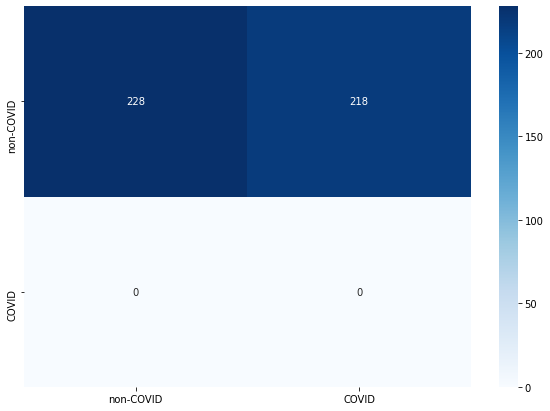

Epoch:7/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


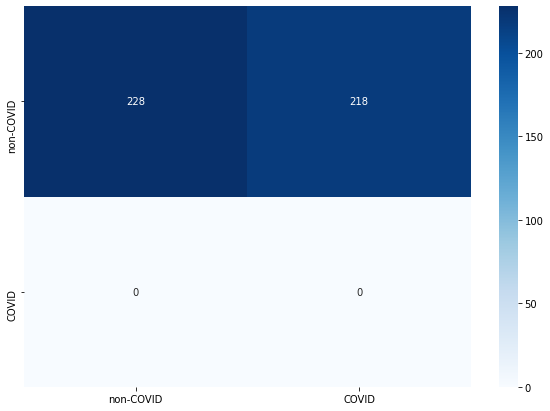

Epoch:8/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


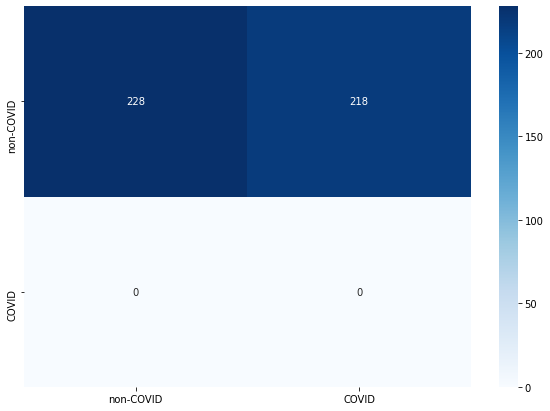

Epoch:9/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %


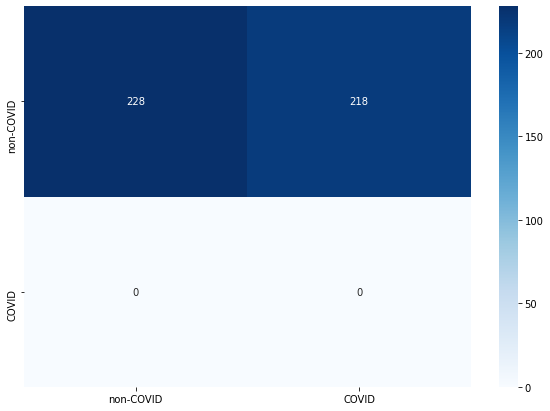

Epoch:10/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.28 % AVG Test Acc 51.12 %
Fold 4
<function cross_entropy at 0x7fc09dd60ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

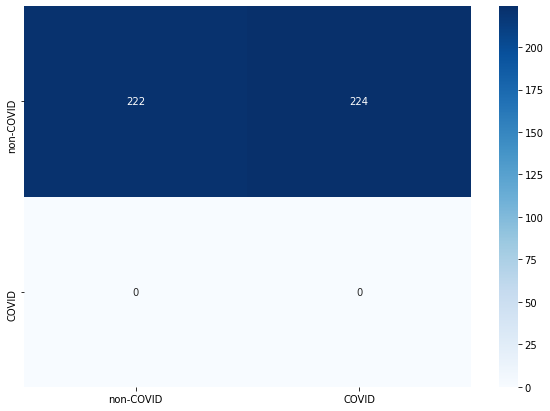

Epoch:1/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.45 % AVG Test Acc 49.78 %


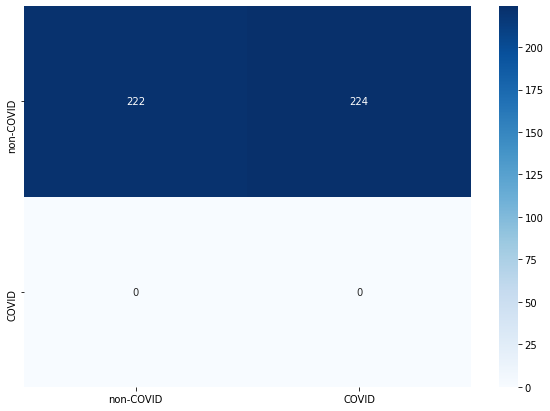

Epoch:2/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


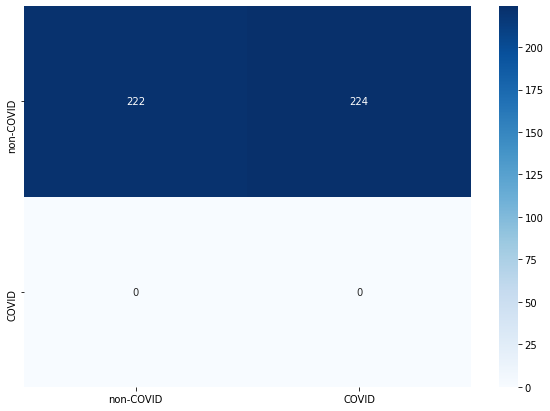

Epoch:3/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


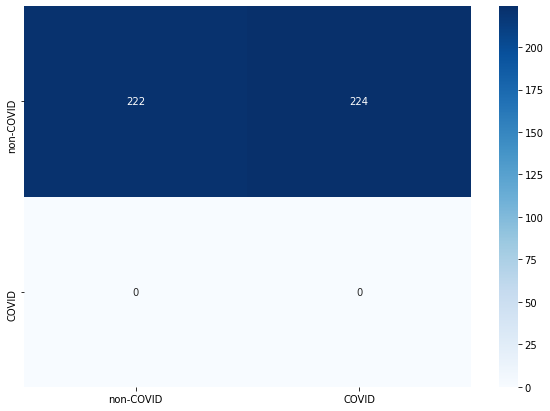

Epoch:4/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


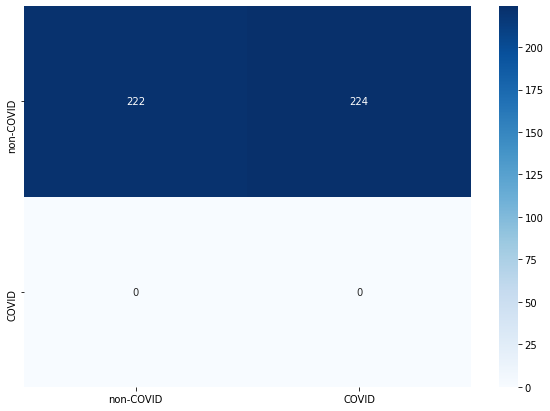

Epoch:5/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


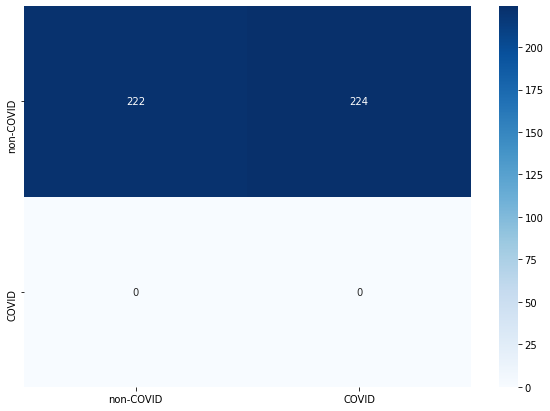

Epoch:6/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


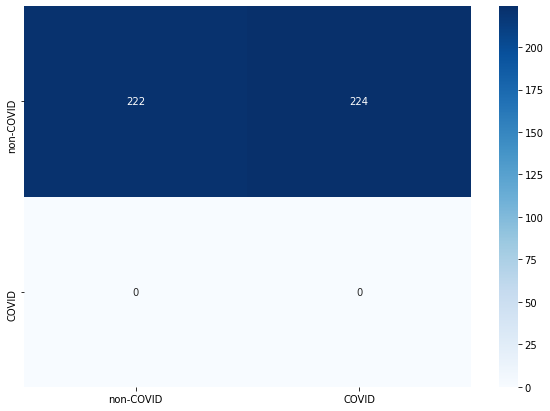

Epoch:7/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


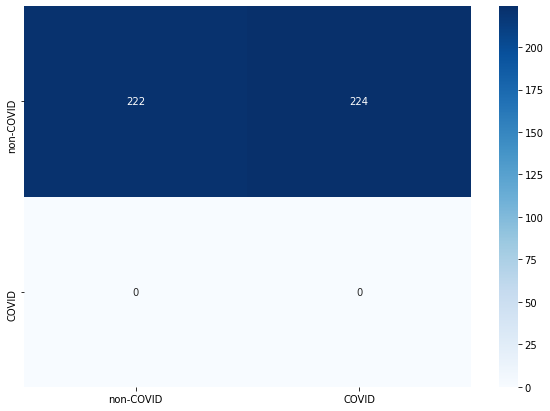

Epoch:8/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


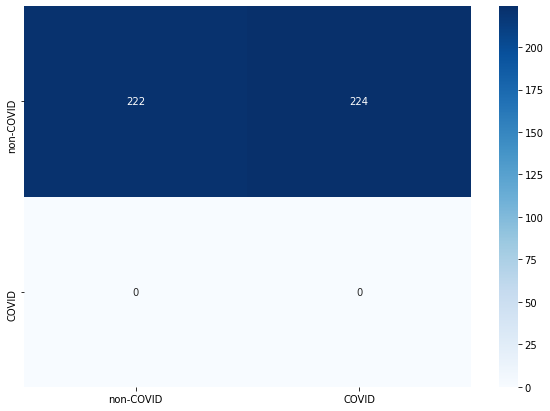

Epoch:9/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %


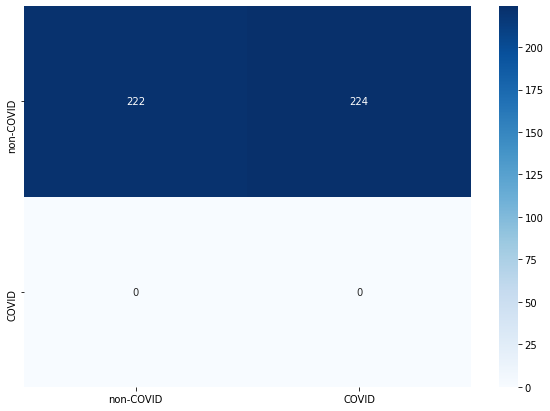

Epoch:10/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.62 % AVG Test Acc 49.78 %
Fold 5
<function cross_entropy at 0x7fc09dd60ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

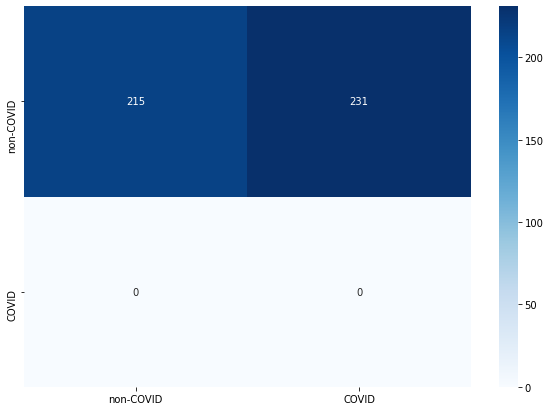

Epoch:1/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 50.78 % AVG Test Acc 48.21 %


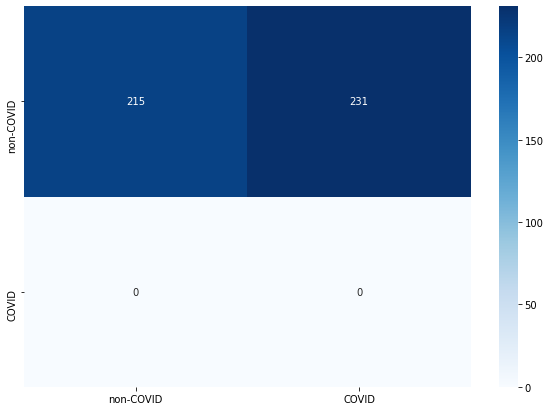

Epoch:2/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


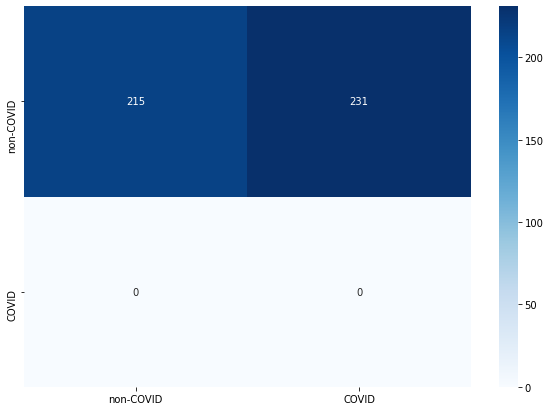

Epoch:3/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


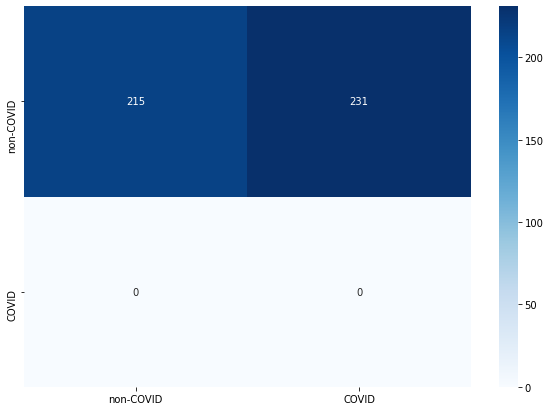

Epoch:4/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


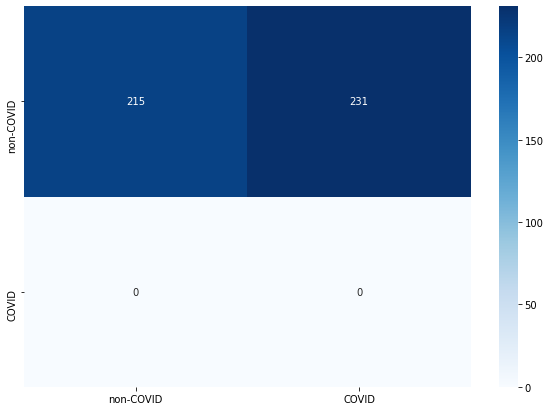

Epoch:5/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


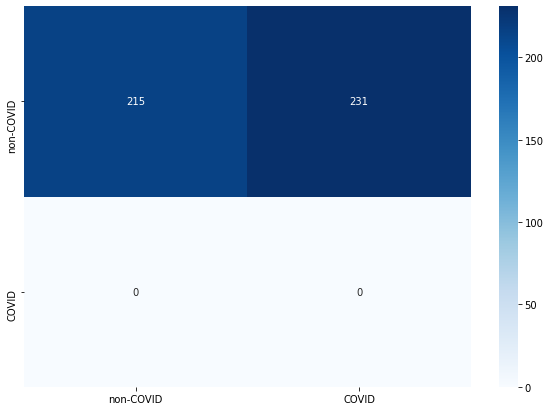

Epoch:6/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


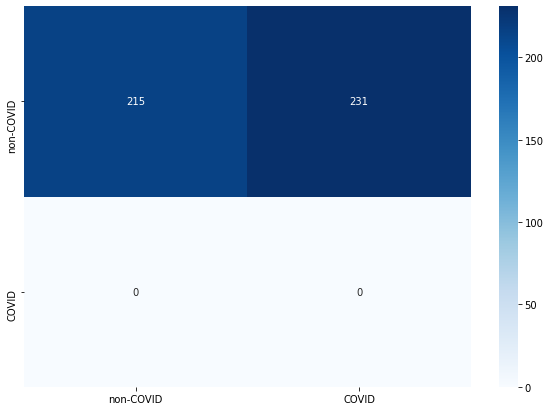

Epoch:7/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


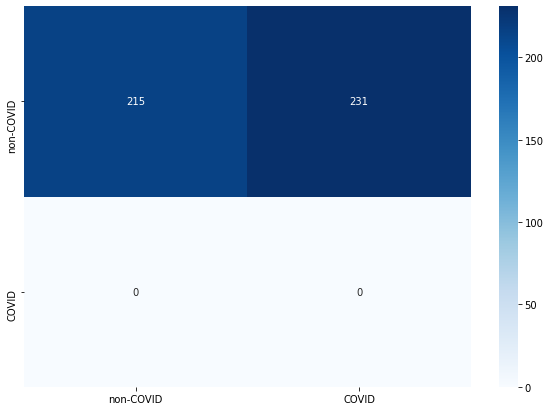

Epoch:8/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


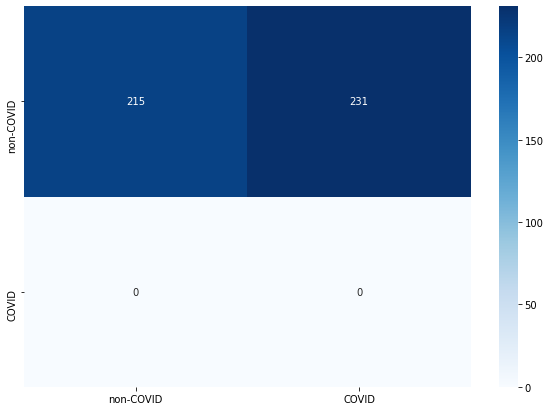

Epoch:9/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


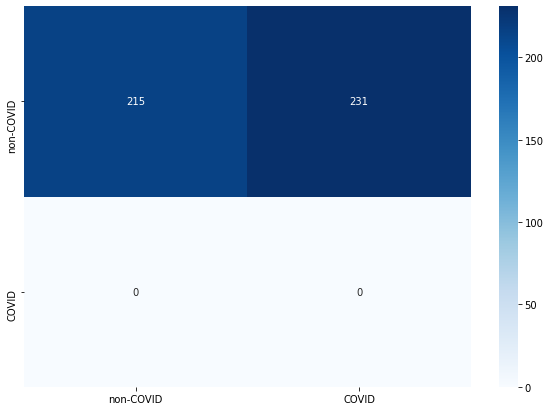

Epoch:10/10 AVG Training Loss:0.693 AVG Test Loss:0.693 AVG Training Acc 51.01 % AVG Test Acc 48.21 %


In [22]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [23]:
print("SQUEEZENET  With out Freezing Cross Entropy+CV ")
cv_results(folderperf)

SQUEEZENET  With out Freezing Cross Entropy+CV 
Performance of 5 fold cross validation
Average Training Loss: 0.702 	 Average val Loss: 0.693 	 Average Training Acc: 50.46 	 Average val Acc: 50.48
Max Training Acc: 51.34 	 Max val Acc: 53.91


In [24]:
def fold_plot(folderperf,num_rows,suptitle,num_cols=2):
  fig, axes = plt.subplots(num_rows, num_cols,figsize=(15, 15))
  fig.suptitle(suptitle,fontsize=16,y=1.02)
  for fold in range(1,num_rows+1):
    fold_results=folderperf['fold'+str(fold)]
    # 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]
    train_loss=fold_results['train_loss']
    test_loss=fold_results['test_loss']
    train_acc=fold_results['train_acc']
    test_acc=fold_results['test_acc']
    axes[fold-1][0].plot(train_loss, label='train')
    axes[fold-1][0].plot(test_loss, label='validation')
    axes[fold-1][0].set_title("Train-Validation loss")
    axes[fold-1][0].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][0].set_ylabel('Loss', fontsize=12)
    axes[fold-1][0].legend(loc='best')

    axes[fold-1][1].plot(train_acc, label='train')
    axes[fold-1][1].plot(test_acc, label='validation')
    axes[fold-1][1].set_title("Train-Validation Acc")
    axes[fold-1][1].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][1].set_ylabel('Accuracy', fontsize=12)
    axes[fold-1][1].legend(loc='best')
  plt.tight_layout()
  plt.show()

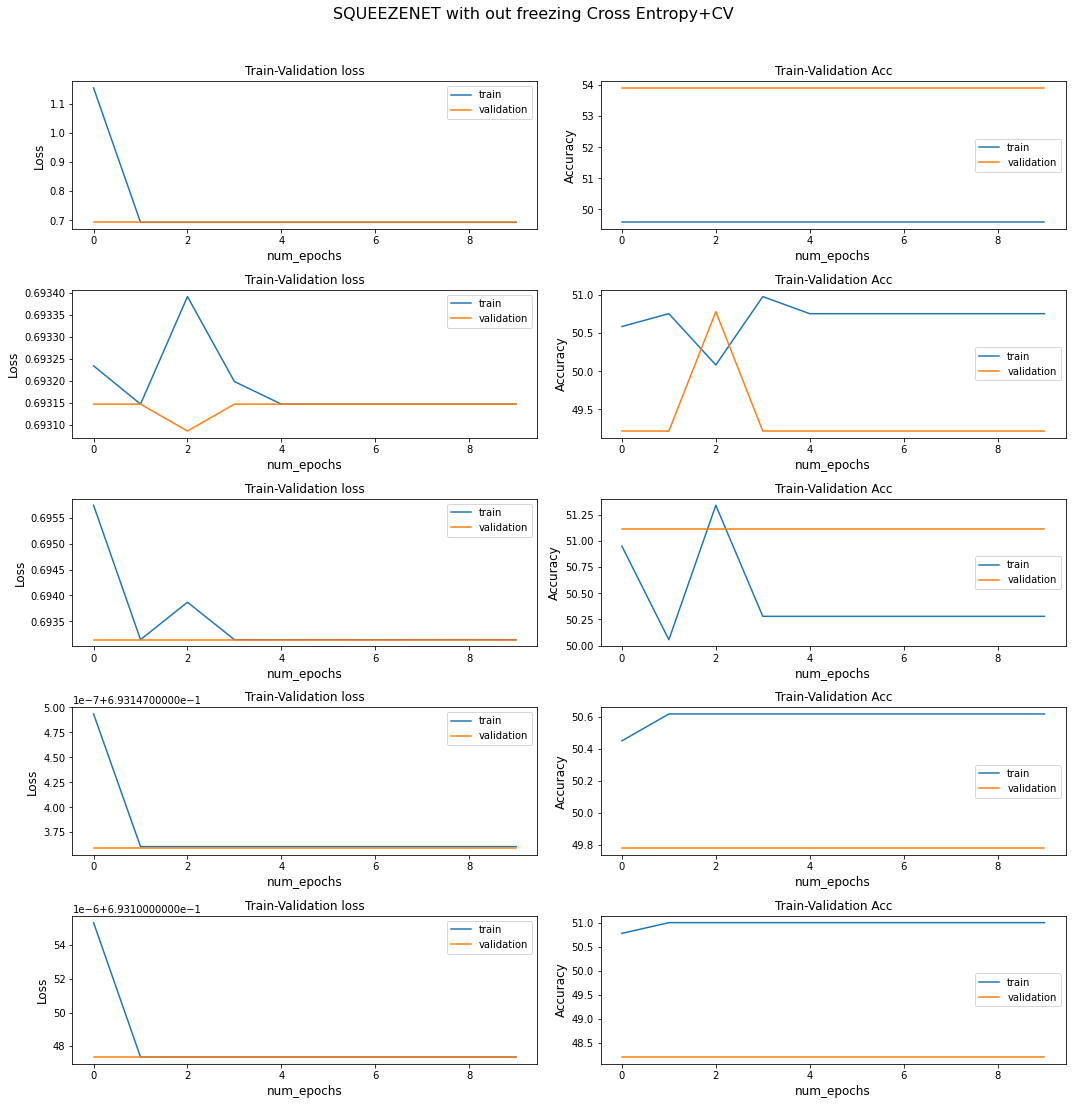

In [25]:
fold_plot(folderperf,k,"SQUEEZENET with out freezing Cross Entropy+CV ")

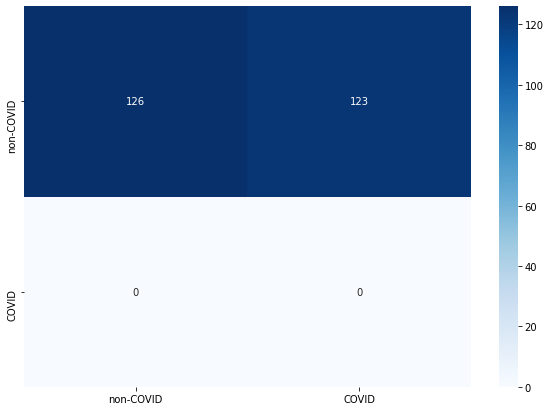

SQUEEZENET - without freezing + Cross Entropy + CV
Test Loss : 0.69 	 Test Accuracy : 50.60


In [26]:
# model,device,dataloader,test_dataset,loss_fn=F.cross_entropy,grad_clip=0
loss_func=F.cross_entropy
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_func)
print("SQUEEZENET - without freezing + Cross Entropy + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))

### Focal Loss

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [28]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy
gamma=2
alpha=0.25
k=5



In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [30]:
model=SQUEEZENET_WoF(num_classes)
to_device(model,device)

SQUEEZENET_WoF(
  (network): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

Fold 1
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


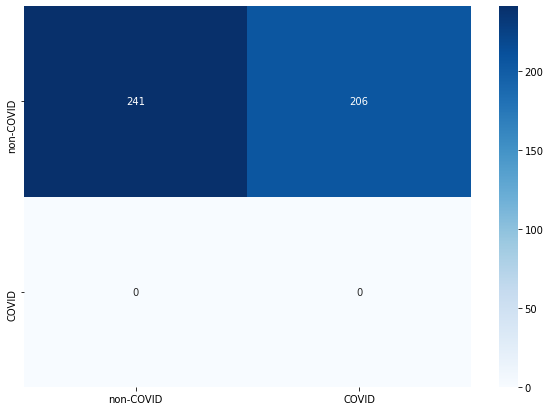

Epoch:1/10 AVG Training Loss:69.194 AVG Test Loss:0.083 AVG Training Acc 49.86 % AVG Test Acc 53.91 %


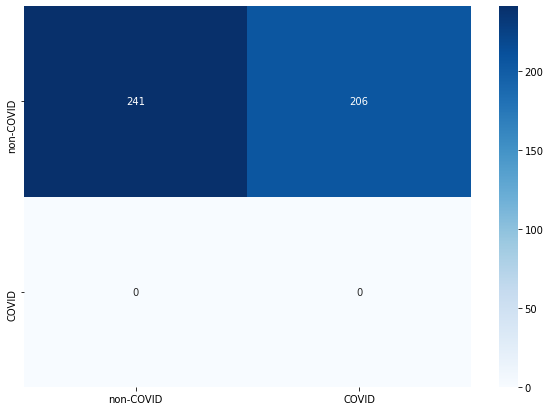

Epoch:2/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


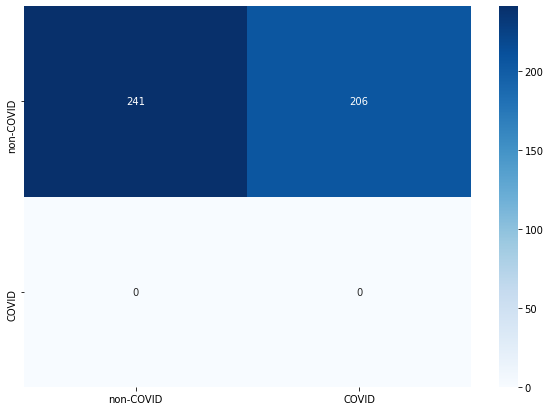

Epoch:3/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


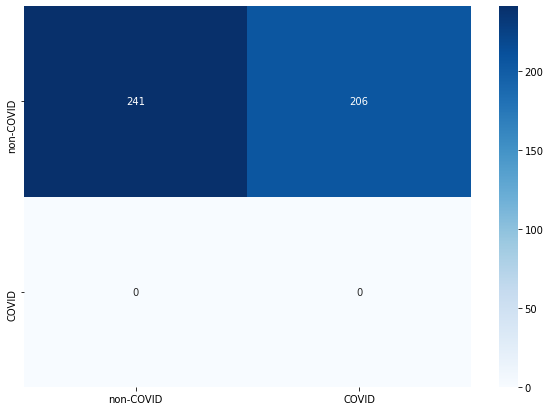

Epoch:4/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


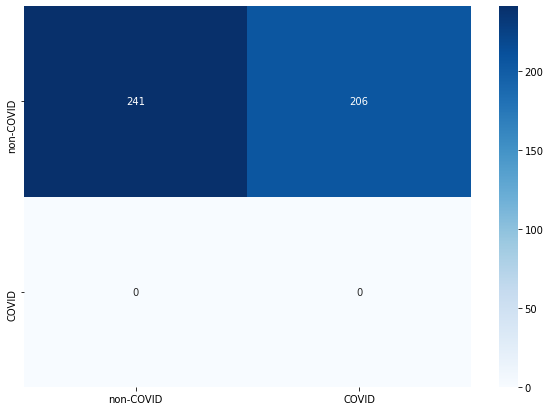

Epoch:5/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


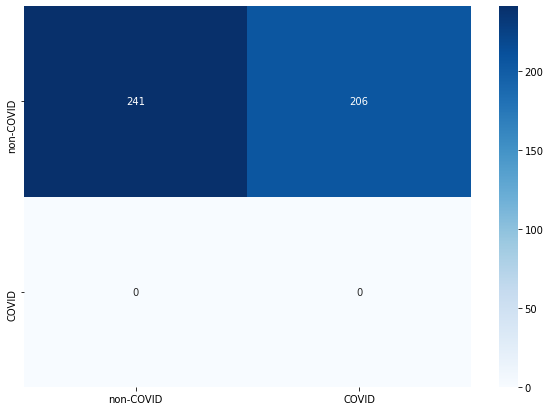

Epoch:6/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


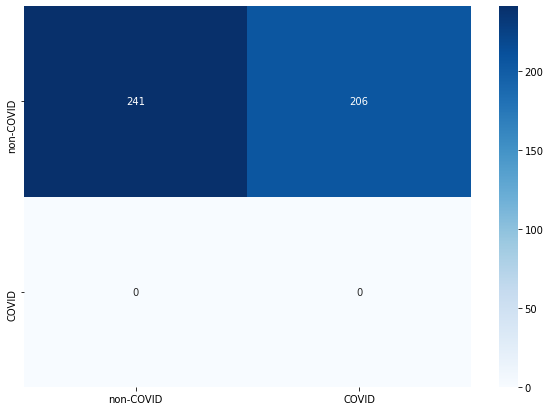

Epoch:7/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


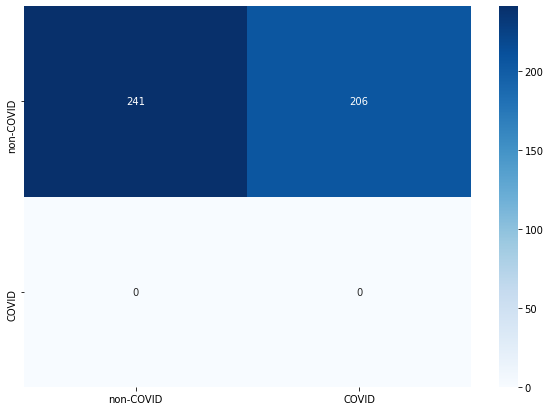

Epoch:8/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


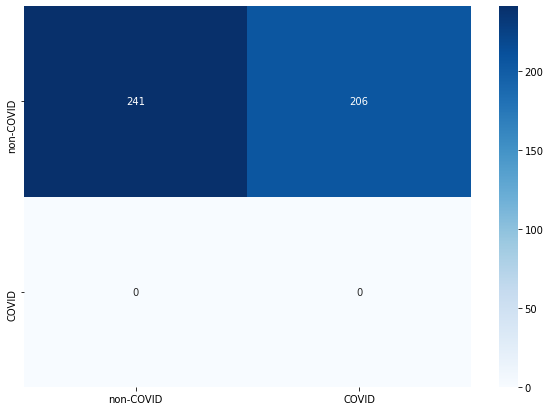

Epoch:9/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %


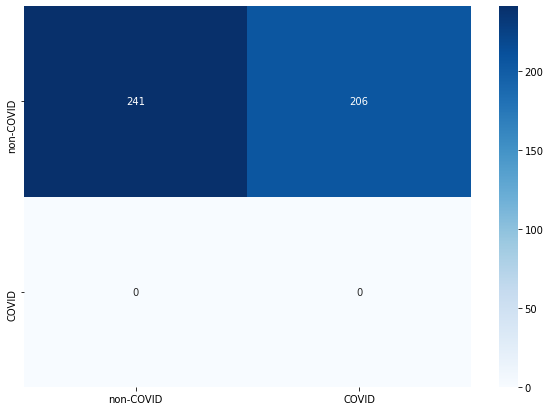

Epoch:10/10 AVG Training Loss:0.087 AVG Test Loss:0.083 AVG Training Acc 49.58 % AVG Test Acc 53.91 %
Fold 2
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

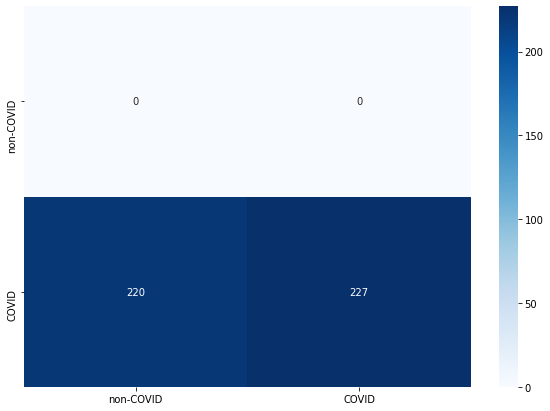

Epoch:1/10 AVG Training Loss:0.096 AVG Test Loss:0.073 AVG Training Acc 50.03 % AVG Test Acc 50.78 %


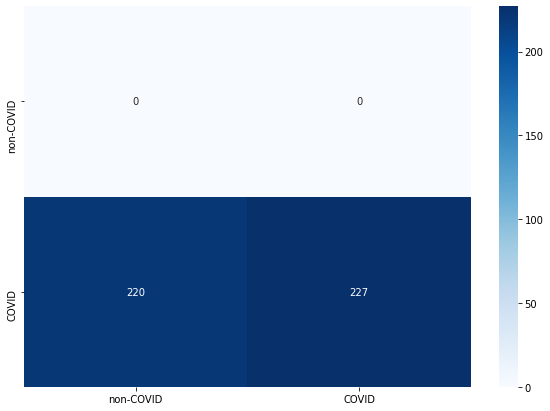

Epoch:2/10 AVG Training Loss:0.073 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


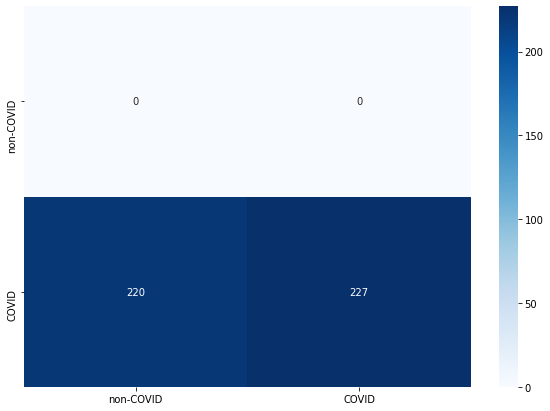

Epoch:3/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


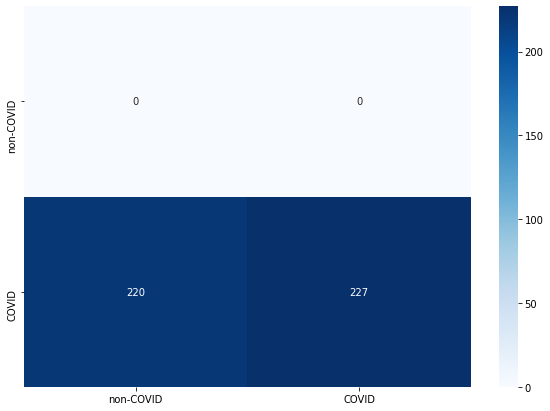

Epoch:4/10 AVG Training Loss:0.073 AVG Test Loss:0.073 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


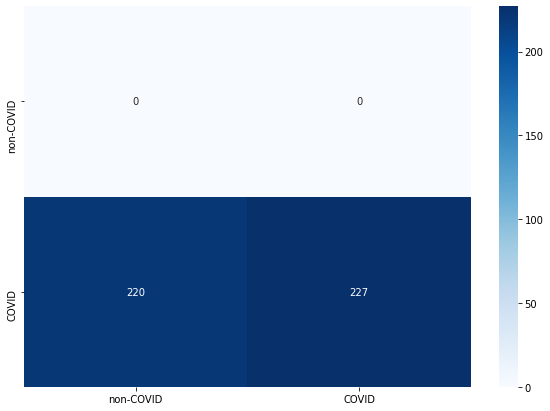

Epoch:5/10 AVG Training Loss:0.072 AVG Test Loss:0.073 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


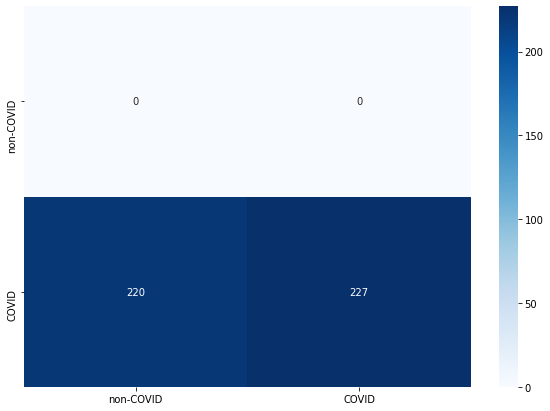

Epoch:6/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


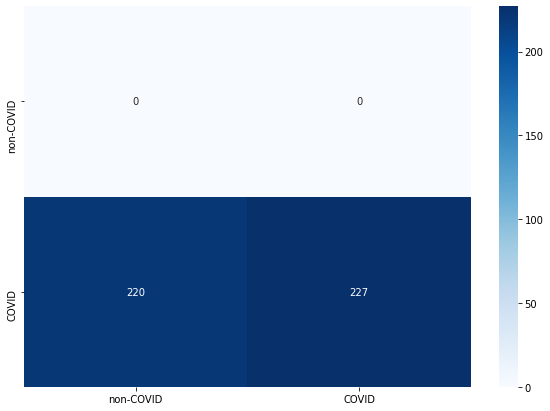

Epoch:7/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


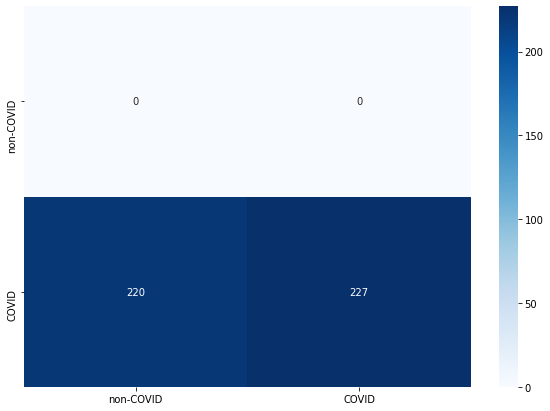

Epoch:8/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


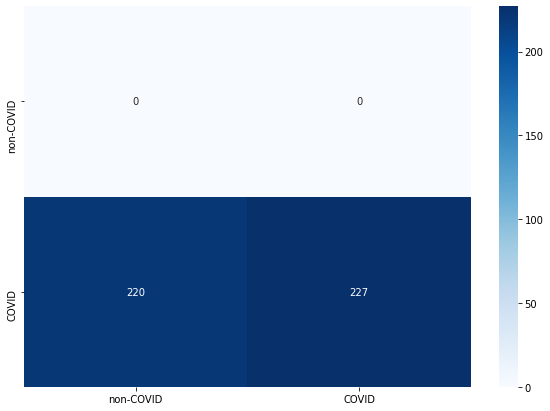

Epoch:9/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %


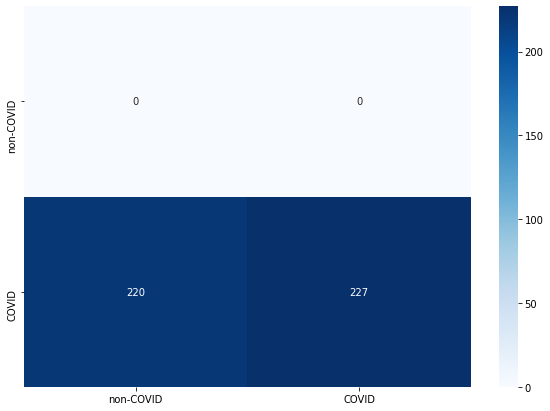

Epoch:10/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.24 % AVG Test Acc 50.78 %
Fold 3
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

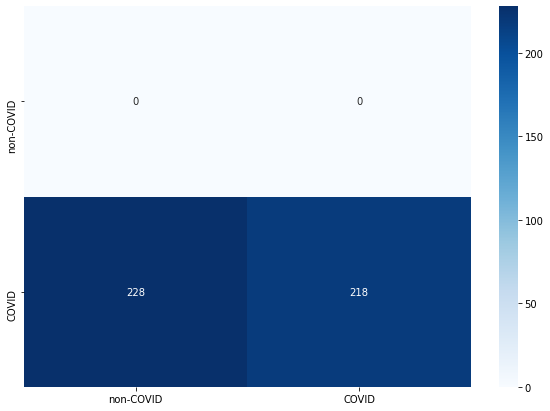

Epoch:1/10 AVG Training Loss:0.073 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


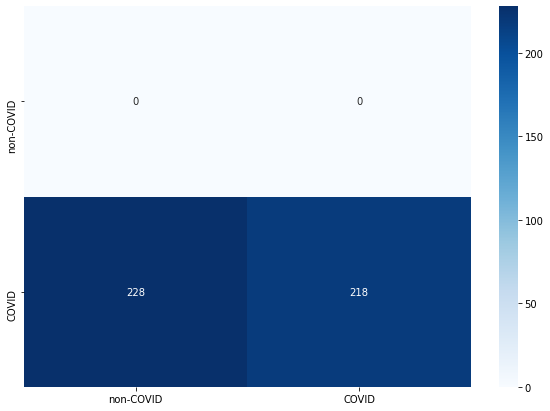

Epoch:2/10 AVG Training Loss:0.072 AVG Test Loss:0.073 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


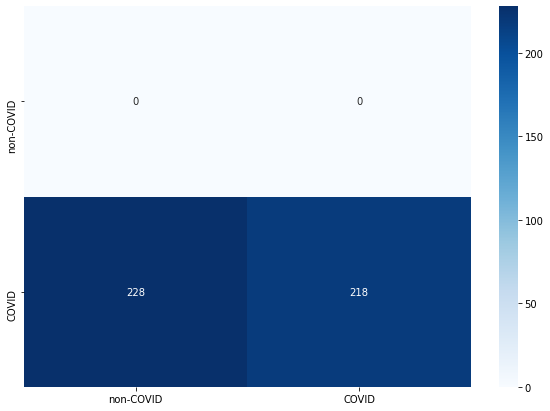

Epoch:3/10 AVG Training Loss:0.072 AVG Test Loss:0.073 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


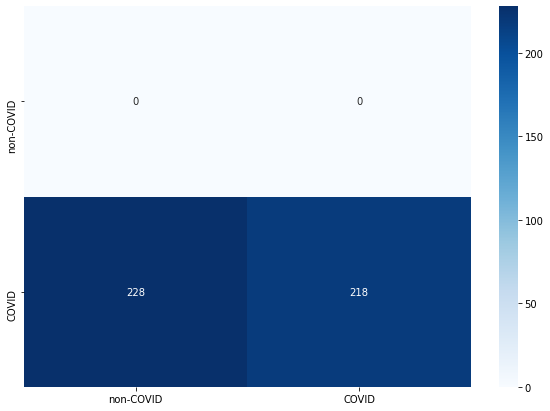

Epoch:4/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


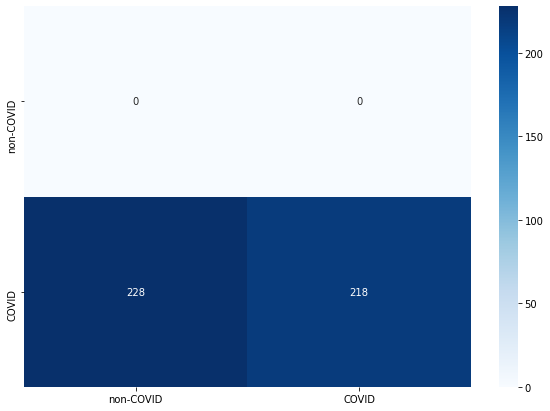

Epoch:5/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


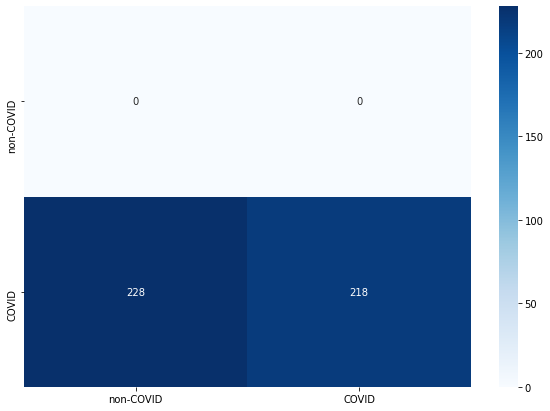

Epoch:6/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


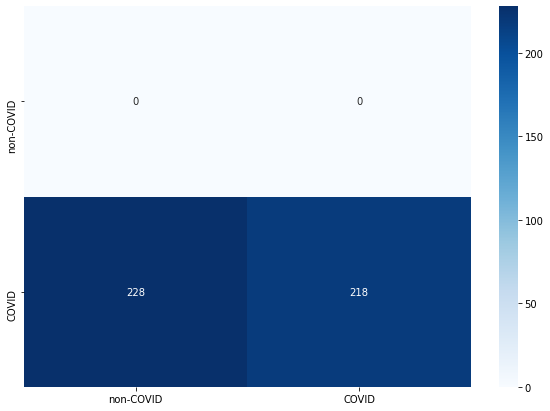

Epoch:7/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


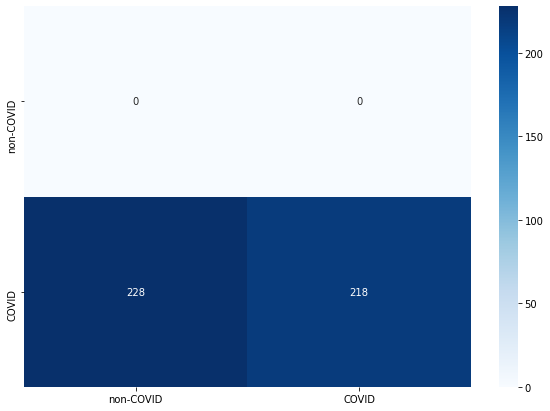

Epoch:8/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


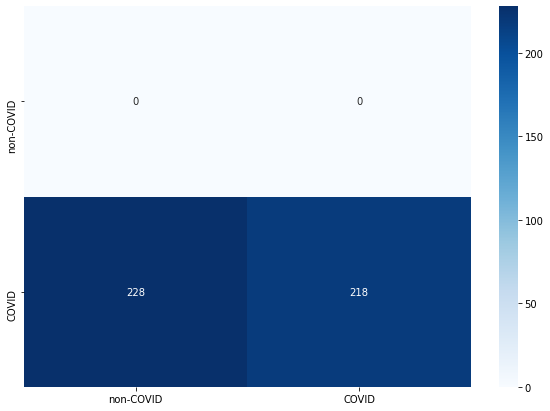

Epoch:9/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %


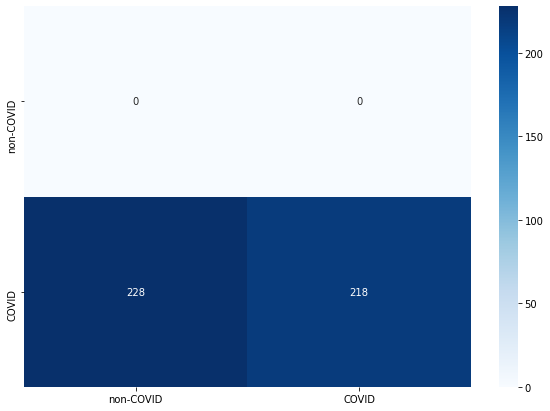

Epoch:10/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.72 % AVG Test Acc 48.88 %
Fold 4
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

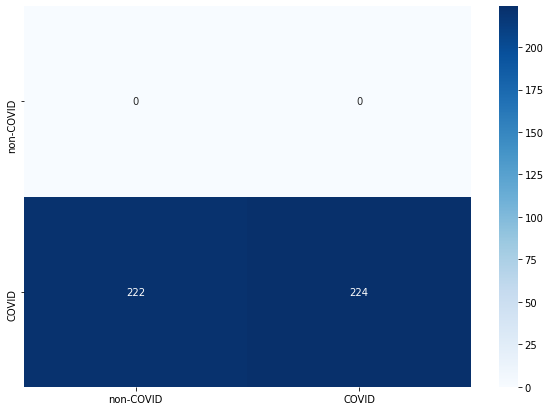

Epoch:1/10 AVG Training Loss:0.072 AVG Test Loss:0.073 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


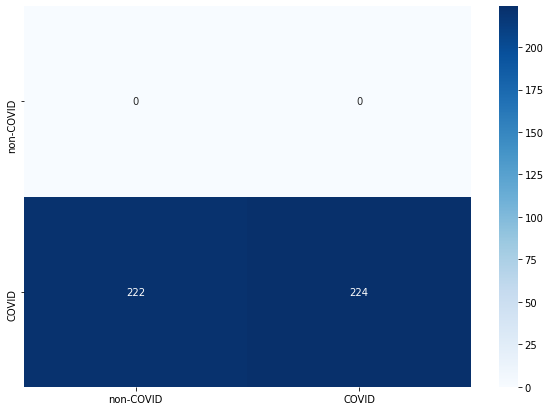

Epoch:2/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


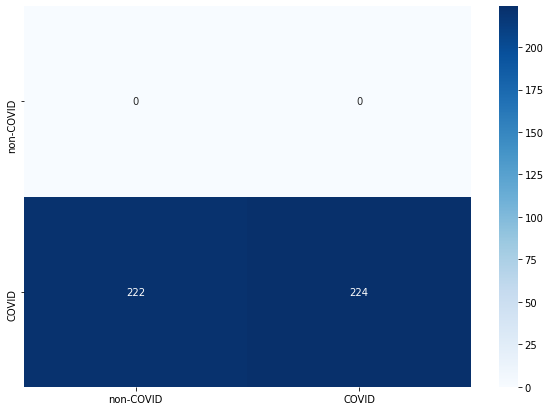

Epoch:3/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


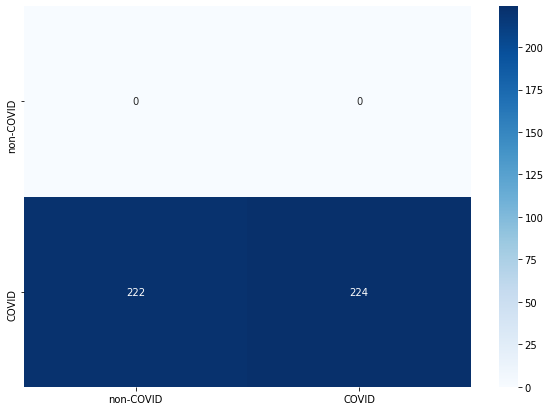

Epoch:4/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


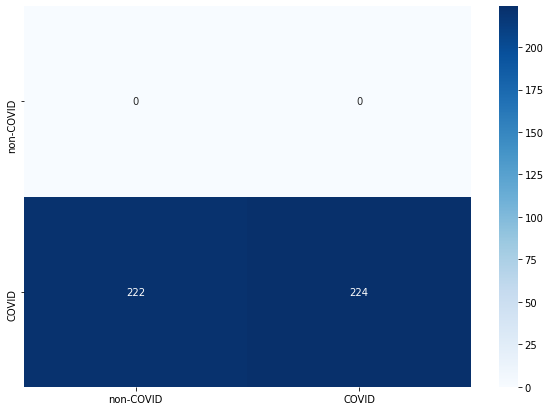

Epoch:5/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


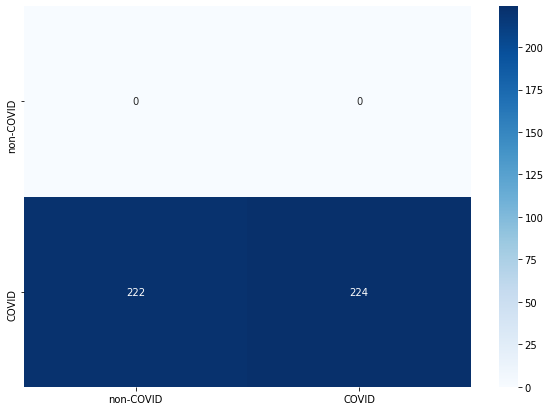

Epoch:6/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


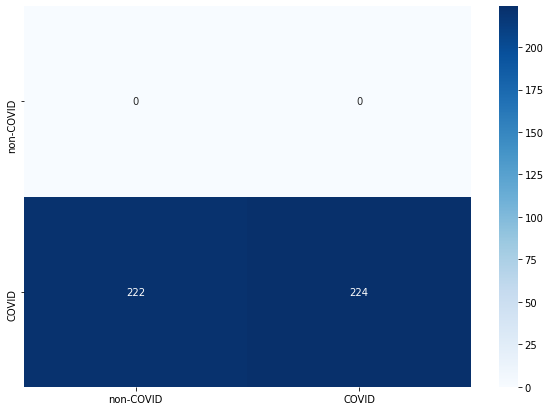

Epoch:7/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


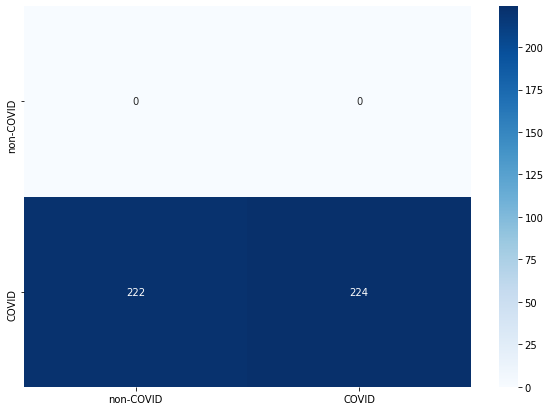

Epoch:8/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


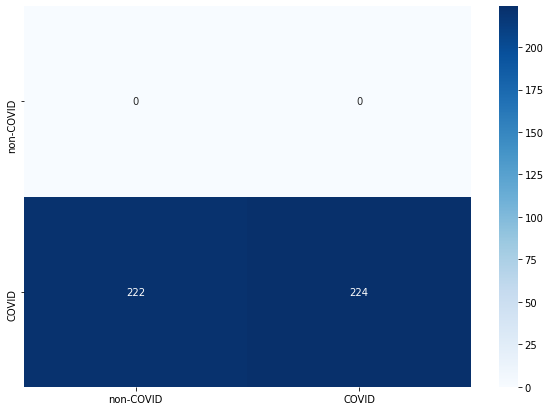

Epoch:9/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %


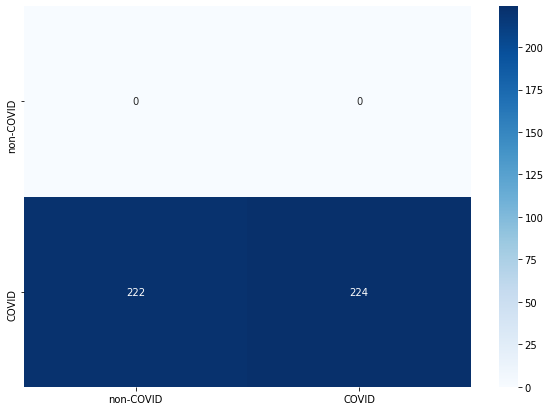

Epoch:10/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 49.38 % AVG Test Acc 50.22 %
Fold 5
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

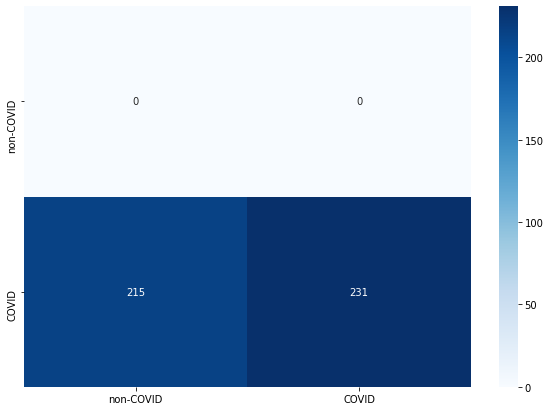

Epoch:1/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


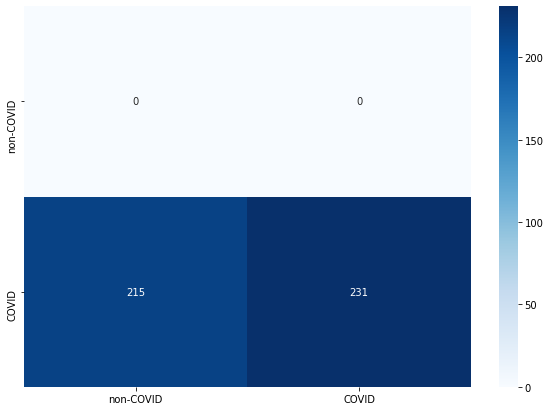

Epoch:2/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


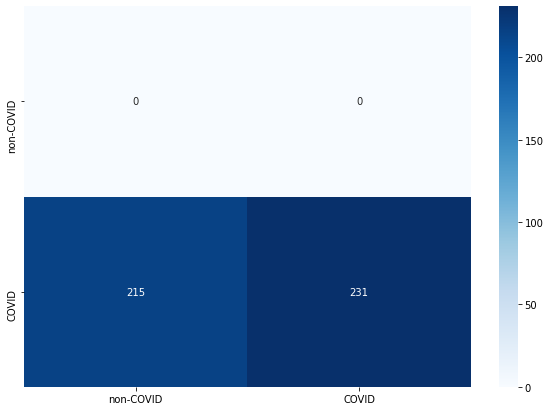

Epoch:3/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


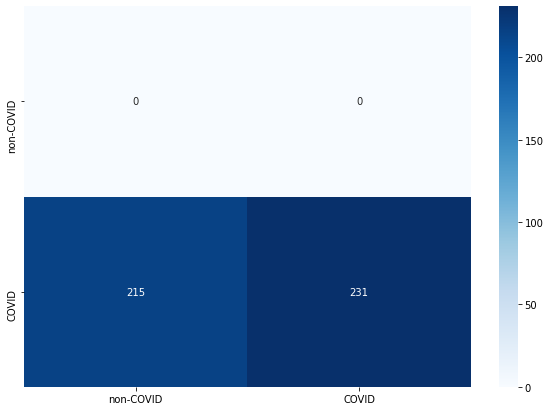

Epoch:4/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


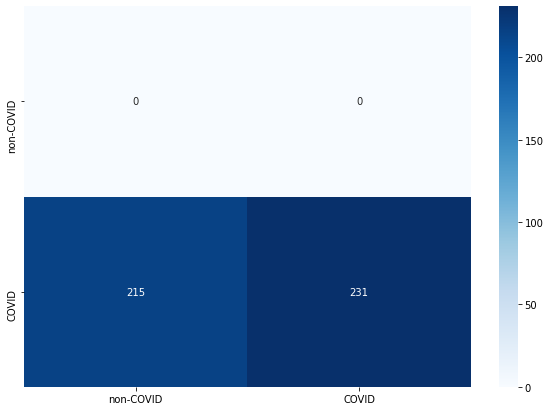

Epoch:5/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


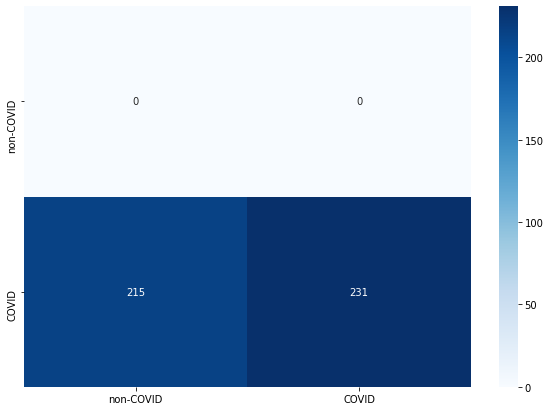

Epoch:6/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


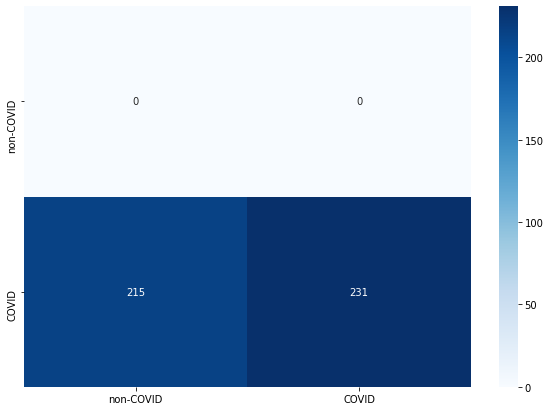

Epoch:7/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


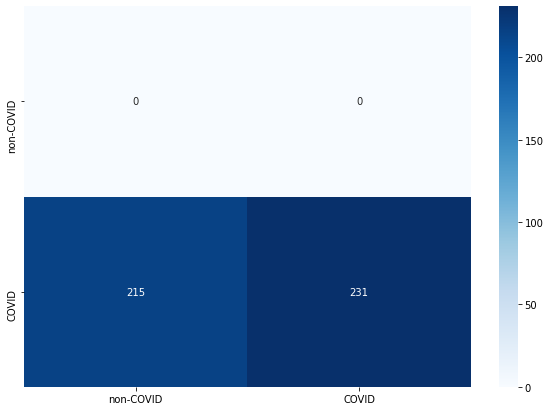

Epoch:8/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


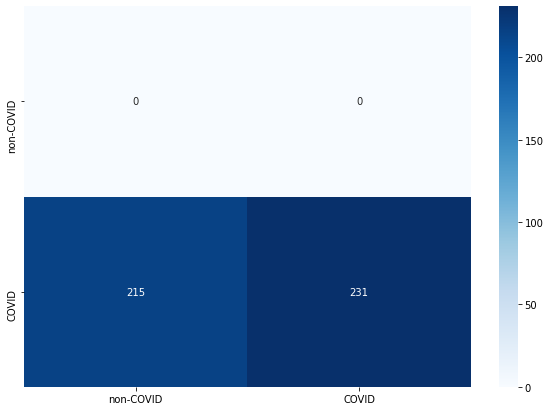

Epoch:9/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


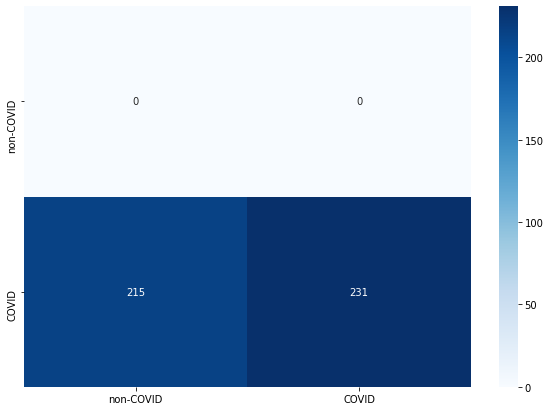

Epoch:10/10 AVG Training Loss:0.072 AVG Test Loss:0.072 AVG Training Acc 48.99 % AVG Test Acc 51.79 %


In [31]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [32]:
print("SQUEEZENET  With out Freezing Focal Loss+CV ")
cv_results(folderperf)

SQUEEZENET  With out Freezing Focal Loss+CV 
Performance of 5 fold cross validation
Average Training Loss: 1.458 	 Average val Loss: 0.074 	 Average Training Acc: 49.41 	 Average val Acc: 51.12
Max Training Acc: 50.03 	 Max val Acc: 53.91


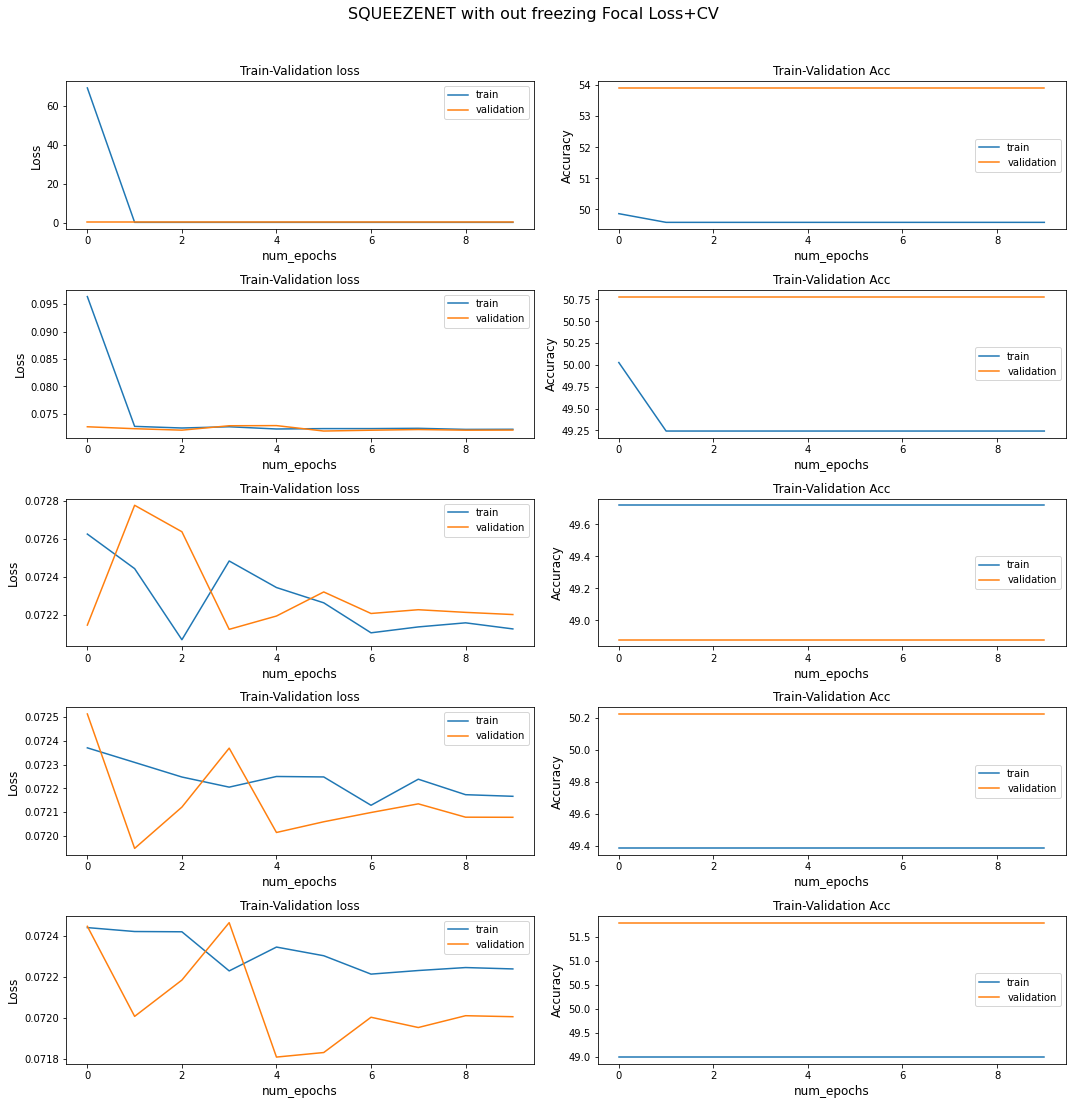

In [33]:
fold_plot(folderperf,k,"SQUEEZENET with out freezing Focal Loss+CV ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


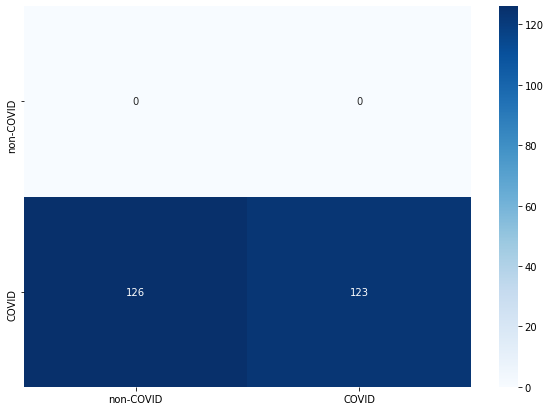

SQUEEZENET - without freezing + focal loss + CV
Test Loss : 0.07 	 Test Accuracy : 49.40


In [34]:
# model,device,dataloader,test_dataset,loss_fn=F.cross_entropy,grad_clip=0
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_func)
print("SQUEEZENET - without freezing + focal loss + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))